In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import toml
import timeit
import pandas as pd
import math
import os

In [6]:
param = toml.load("config.toml")
path = param.get("path")
minFeatures = param.get("minFeatures")
camera_path = param.get("camera_path")
encoder_path = param.get("encoder_path")
calib = param.get("calib")
NP = param.get("NP")
MAX_RANGE = param.get("MAX_RANGE")

In [3]:
class Visual_Odom:
    def __init__(self,calib_mat,minFeatures):
        self.k = calib_mat
        self.minFeatures = minFeatures 
        self.r = np.zeros([3,3])
        self.t = np.zeros([3,1])
        self.pose = np.eye(4)
        self.x_loc=[]
        self.z_loc=[]
        
        self.kp1 = []
        self.kp2 = []
        self.landmarks= []
        self.matches = None
        
    def process_features(self,first_frame,second_frame,calib_matrix):
        
        self.landmarks = []
        #create sift detector object
        sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=10)
        
        # Extract sfit features from current and next frame
        keypoints_1, descriptors_1 = sift.detectAndCompute(first_frame,None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(second_frame,None)
        
        # Filter those keypoints that are matched across frames only
        keypoints_1, keypoints_2 = self.filter_features(descriptors_1, descriptors_2, keypoints_1, keypoints_2)
        
        # Compute Essential matrix from feature list
        E, mask = cv2.findEssentialMat(keypoints_1, keypoints_2, self.k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        
        # Compute rotation and translation matrices
        _, self.r, self.t, mask = cv2.recoverPose(E, keypoints_2, keypoints_1, self.k)
        
        #Compute inverse of intrinisc and extrinsic matrix 
        # to get real world coordinates
        calib_inv = np.linalg.inv(calib_matrix)
        R = np.column_stack((self.r, self.t))
        r_inv = np.linalg.pinv(R)
        
        #Recover real world coordinates of first 10 landmarks
        for i in range(10):
            pose = np.hstack((keypoints_1[i], [1.0]))
            pose = np.reshape(pose,(3,1))
            ld = calib_inv @ pose
            ld = r_inv @ ld
            ld = ld * 1 #(1/ld[3])
            self.landmarks.append([ld[0],ld[2]])
            
            
        
        return self.landmarks, self.r, self.t
    
    def filter_features(self,descriptors_1, descriptors_2, keypoints_1, keypoints_2):
        
        #Create brute force matcher object 
        bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

        self.matches = bf.match(descriptors_1, descriptors_2)
        
        #sort matches based on distance.
        #Lower distance between descripors -> better the match
        self.matches = sorted(self.matches, key = lambda x:x.distance)

        pts1 = []
        pts2 = []
        
        idx =  self.matches[0:self.minFeatures]

        # Gtaher kepyoint objects of filtered matches from respective frames
        for i in idx:
            pts1.append(keypoints_1[i.queryIdx].pt)
            pts2.append(keypoints_2[i.trainIdx].pt)
            self.kp1.append(keypoints_1[i.queryIdx])
            self.kp2.append(keypoints_2[i.trainIdx])

        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

        return pts1, pts2
    
    def pose_calc(self,r,t):
        
        #Combine rotation and translation matrices
        new_pose = np.column_stack((r, t))
        new_pose = np.vstack((new_pose, np.array([0,0,0,1])))
        
        self.pose = self.pose @ new_pose
        
        # Extract x and z coordinate
        self.x_loc.append(self.pose[0, -1])
        self.z_loc.append(self.pose[2, -1])
        
    def plot_trajectory(self):
        plt.figure(figsize=(6, 6), dpi=100)
        plt.title('VO Trajectory')
        plt.ylabel('Z')
        plt.xlabel('X')
        plt.gca().invert_xaxis()
        plt.plot(self.x_loc, self.z_loc)
        plt.show()
        
    def plot_landmarks(self):
        plt.figure(figsize=(6, 6), dpi=100)
        plt.title('Landmarks')
        plt.ylabel('Z')
        plt.xlabel('X')
        plt.scatter(*zip(*self.landmarks))
        plt.show()

In [4]:
class ParticleFilter:
    def __init__(self, num_particles, process_noise):
        self.min_dist = 0.5
        self.max_dist = 10
        self.particle_poses = np.array([[0, 0, np.pi/2]]*num_particles)
        self.num_particles = num_particles
        self.weights = np.ones(num_particles)/ num_particles
        self.process_noise = process_noise

    
    def motion_update(self, v, w, dt=0.01):
        for i in range(self.num_particles):
            noise_sample = []
            for pn in self.process_noise:
                noise_sample.append(np.random.normal(scale=pn))
            x, y, theta = self.particle_poses[i]
            x = x + v*np.cos(theta)*dt + noise_sample[0]
            y = y + v*np.sin(theta)*dt + noise_sample[1]
            theta = theta + w*dt + noise_sample[2]
            theta = np.arctan2(np.sin(theta), np.cos(theta))
            self.particle_poses[i] = [x, y, theta]
    
    def calc_weighted_scores(self, scores):
        adjusted_scores = scores - np.min(scores)
        self.weights *= adjusted_scores
        sum_weights = np.sum(self.weights)
        self.weights /= sum_weights
        
    def resample_particles(self):
        sum_weights = np.sum(self.weights)
        sum_weights_squared = np.sum(self.weights**2)
        neff = (sum_weights ** 2) / sum_weights_squared
        cumulative_sum = np.cumsum(self.weights)
        if neff < 40.0:
            for i in range(1, self.num_particles):
                j = np.argmax(cumulative_sum>np.random.random())
                self.particle_poses[i] = self.particle_poses[j]
            self.weights = np.ones(self.num_particles)/ self.num_particles


## Reading Datasets 

In [7]:
df = pd.read_csv(encoder_path)

#Get first timestamp
ini = df["time"][0]

# Generate delta t for each timestep
df["dt"] = df["time"].diff(1)
df=df.drop([0])

In [20]:
l=[]
cap = cv2.VideoCapture(camera_path)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
while(cap.isOpened()):
    frame_exists, curr_frame = cap.read()
    if frame_exists:
        timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC)/1000)
        l.append(curr_frame)
    else:
        break
timestamps = np.array(timestamps)
timestamps = np.delete(timestamps, 0)

In [48]:
#Sampling Dataset
k=[]
for i in range(len(l)):
    if not(i % 2):
        k.append(l[i])

check = []
for i in range(timestamps.shape[0]):
    if(not(i % 2)):
        check.append(timestamps[i]) 

## Functions for assigning scores 

In [27]:
def compute_scores(landmarks, measured, particles, pose): 
    '''
    Function computes weights based on error difference between actual observation 
    and observations made from each of the particles.
    
    landmarks: real world pose of landmarks
    measured: distance observation made from current pose to each landmark
    particles: poses of each particle
    pose: current pose
    '''
    
    #Initialize Weights for each particle to 0
    scores = np.zeros(particles.shape[0])
    for i in range(particles.shape[0]):
        p = particles[i]
        d = np.zeros(landmarks.shape[0])
        
        #Get distance to landmarks for ith particle
        for j in range(landmarks.shape[0]):
            d[j] = get_distance(landmarks[j], p)

        #Compute error in pose and orientation
        score = (0.85 * np.sum(np.abs(measured - d))) + (0.15 * np.abs(pose[2] - p[2]))
        score = (1 / (score + 1))
        scores[i] = score
    return scores

In [28]:
def observation(landmarks, pose, delta):
    '''
    Function computes distance from pose to each of the landmarks and returns the array containing it
    
    landmarks: real world pose of each landmark
    pose: current pose
    delta: displacement from previous observation timestep
    '''
    d = np.zeros(landmarks.shape[0])
    for i in range(landmarks.shape[0]):
        d[i] = get_distance(landmarks[i], [sum(i) for i in zip(pose, delta)])
    return d

In [29]:
def get_distance(landmark, pose):
    '''
    Function computes distance between 2 points
    landmark: coordinate of 1 landmark
    pose: current pose
    '''
    dx = pose[0] - landmark[0]
    dy = pose[1] - landmark[1]
    return math.hypot(dx, dy)

## Run Simulation 

In [49]:
#Set timestamp of start of simulation to 0
time = 0.0

#Copy camera frames and timestamps
check2 = check
frames = k

#Initialise variables
camera = False
poses = []
mem_pose = np.asarray([0.0, 0.0, np.pi/2])

#Set Process noise
motion_noise = (0.03/np.sqrt(10), 0.03/np.sqrt(10), 0.02/np.sqrt(10))


In [50]:
pf = ParticleFilter(NP, motion_noise)
X = Visual_Odom(np.asarray(calib), minFeatures)
for i in range(len(df)-1):
    
    #Get control inputs
    dt = df["dt"][i+1]
    v = df["v"][i+1]
    w = df["w"][i+1]
    
    #Update motion model
    pf.motion_update(v,w,dt)

    #Check if camera interrupt raised
    #Called only when sim time equals frame timestep
    if(time > check2[1]):
        camera = True
        
        #Discard timestep to avoid multiple calls 
        check2 = check2[1:]
     
    if(camera):
        
        if(np.abs(v) > 0.01):     
            #Camera observation made
            frame1 = frames[0]
            frame2 = frames[1]

            #Get pose of landmarks
            landmarks, r, t = X.process_features(frame1, frame2, np.asarray(calib))
            landmarks = np.asarray(landmarks)

            #Compute displacement made from previous observation timestep
            delta = [pose[0] - mem_pose[0], pose[1] - mem_pose[1]]

            #Get distance to landmarks from current pose
            d = observation(landmarks, pose, delta)

            #Calculate weights
            scores = compute_scores(landmarks, d, pf.particle_poses, pose)
            #print(scores)
            pf.calc_weighted_scores(scores)
        
        #Set pose to most probable particle
        best = np.argmax(pf.weights)
        pose = pf.particle_poses[best]
        
        #Record current pose to be used in next observation
        mem_pose = pose
        
        #Discard frame and Clear Interrupt flag
        frames = frames[1:]
        camera = False
        
    else:
        best = np.argmax(pf.weights)
        pose = pf.particle_poses[best]
        

    pf.resample_particles()
    poses.append(np.copy(pose))
        
    if(not(i%500)):
        print(i)
        
    # Increment Simulation time
    time += dt

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


IndexError: list index out of range

## Plot Trajectory 

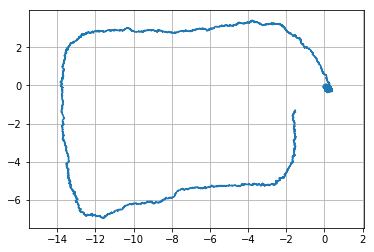

In [51]:
odo_poses = np.array(poses)
plt.figure()
plt.axes().set_aspect("equal","datalim")

plt.plot(odo_poses[:,0], odo_poses[:,1])

plt.grid()